In [1]:
import numpy as np
import matplotlib.pyplot as plt

import src.classificationutils as cu
import src.utils as ut
import dataset_stats

from skimage.color import label2rgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

import skimage.io as sio

import pandas as pd

import torch
import torch.nn.functional as F
from torchvision import transforms

from tqdm import tqdm


In [2]:
# TRAIN_CSV = "train_test_splits/maastotieto/v3_maastotieto_nat0_train.csv"
# TEST_CSV = "train_test_splits/maastotieto/v3_maastotieto_nat0_test.csv"

# TRAIN_CSV = 'train_test_splits/nonoverlap/v3_maastotieto_100m_inv_train.csv'
# TEST_CSV = 'train_test_splits/nonoverlap/v3_maastotieto_100m_inv_test.csv'

TRAIN_CSV = 'v3_100m_inv0_train.csv'
TEST_CSV = 'v3_100m_inv0_test.csv'

CHANNELS = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
OUTPUT_SIZE=(49,49)

DATASET = 'v3'
STATS = dataset_stats.stats[DATASET]

# Extract center pixel as features
class IdentityModel(torch.nn.Module):
    def __init__(self, transform=None):
        super().__init__()
        self.transform = transform
    def forward(self, x):
        if self.transform:
            x = self.transform(x)
        return x.squeeze()

feature_model = IdentityModel(transform=transforms.CenterCrop(1))

# Create dataloaders
fnames_train, labels_train = ut.read_fname_csv(TRAIN_CSV)
fnames_test, labels_test = ut.read_fname_csv(TEST_CSV)
y, le = ut.encode_labels(labels_train+labels_test)
N_CLASSES = len(le.classes_)
print(N_CLASSES)

y_train = le.transform(labels_train)
y_test = le.transform(labels_test)

print("Trainset:")
ut.print_label_counts(y_train,le)
print("Testset:")
ut.print_label_counts(y_test,le)

trainset = cu.ImagePathDataset(fnames_train, 
                              y_train, 
                              output_size=OUTPUT_SIZE,
                              channels=CHANNELS)

testset = cu.ImagePathDataset(fnames_test, 
                              y_test, 
                              output_size=OUTPUT_SIZE,
                              channels=CHANNELS)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=7)
testloader = torch.utils.data.DataLoader(testset, batch_size=7)

y_true_train, _, X_train = cu.torch_predict(feature_model, trainloader, gpu=False)
y_true_test, _, X_test = cu.torch_predict(feature_model, testloader, gpu=False)


27
Trainset:
    count                                  label  y value
0      10  101 Kalliolaet, -rinteet ja -terassit        0
1      10      102 Kalliojyrkänteet ja -seinämät        1
2      33                104 Louhikot ja kivikot        2
3       4          105 Vyörylouhikot ja -kivikot        3
4      25              220 Kasviton kivennäismaa        4
5       3             231 Jäkälä (karukkokangas)        5
6      92               232 Jäkälä-varpu (kuiva)        6
7     241     241 Jäkälä-sammal-varpu (kuivahko)        7
8     291               242 Sammal-varpu (tuore)        8
9      79   251 Sammal-varpu-ruoho (lehtomainen)        9
10     33                      252 Ruoho (lehto)       10
11     56             262 Sammaleinen heinä-sara       11
12     82               263 Ruohoinen heinä-sara       12
13     68           271 Tuntureiden sammalpinnat       13
14      7              311 Varsinaiset korpisuot       14
15      9                312 Korpi-välipintasuot       15
1

In [12]:
import pandas as pd
feature_names = ['Latvuspeitto',
                 'h_nd-2-0_dm',
                 'NDVI_amp_2020',
                 'NDVI_2020_sum',
                 'MaxNDVI_2020'] + [f'S2 2018 Band {i+1}' for i in range(9)]

df = pd.DataFrame(X_test)
df.columns = feature_names
df['class'] = y_true_test
df.to_csv('test.csv')
df

,Latvuspeitto,h_nd-2-0_dm,NDVI_amp_2020,NDVI_2020_sum,MaxNDVI_2020,S2 2018 Band 1,S2 2018 Band 2,S2 2018 Band 3,S2 2018 Band 4,S2 2018 Band 5,S2 2018 Band 6,S2 2018 Band 7,S2 2018 Band 8,S2 2018 Band 9,class
0,2.0,15.0,18.0,931.0,169.0,338.0,727.0,451.0,1271.0,3287.0,3738.0,4046.0,2229.0,1093.0,8
1,47.0,110.0,22.0,914.0,167.0,372.0,706.0,482.0,1286.0,3302.0,3783.0,4218.0,2742.0,1360.0,8
2,0.0,2.0,37.0,822.0,162.0,375.0,681.0,539.0,1223.0,2848.0,3225.0,3497.0,2542.0,1297.0,16
3,0.0,7.0,15.0,893.0,164.0,378.0,672.0,598.0,1264.0,2665.0,3012.0,3450.0,2679.0,1399.0,11
4,0.0,3.0,22.0,893.0,160.0,283.0,450.0,372.0,884.0,1845.0,2130.0,2197.0,2156.0,1151.0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466,5.0,17.0,17.0,723.0,130.0,706.0,809.0,819.0,1054.0,1427.0,1567.0,1669.0,2635.0,2106.0,2
467,0.0,1.0,14.0,841.0,148.0,483.0,705.0,721.0,1126.0,1944.0,2173.0,2253.0,2455.0,1468.0,6
468,0.0,2.0,15.0,764.0,135.0,354.0,515.0,620.0,887.0,1247.0,1448.0,1445.0,1761.0,1085.0,22
469,0.0,1.0,12.0,846.0,148.0,488.0,666.0,686.0,1179.0,1927.0,2141.0,2321.0,2545.0,1527.0,6


In [5]:
X_all = np.concatenate((X_train, X_test))
y_all = np.concatenate((y_train, y_test))

In [6]:
# Train classifier
clf = RandomForestClassifier(n_estimators=100,
                             n_jobs=-1,
                             verbose=1)
clf.classes_ = le.classes_
clf.fit(X_train, y_true_train)

# Evaluation
y_scores = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)
print(clf)
print(classification_report(le.inverse_transform(y_true_test), 
                            le.inverse_transform(y_pred),
                            zero_division=0))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
RandomForestClassifier(n_jobs=-1, verbose=1)
                                       precision    recall  f1-score   support

101 Kalliolaet, -rinteet ja -terassit       0.00      0.00      0.00         6
    102 Kalliojyrkänteet ja -seinämät       0.00      0.00      0.00         4
              104 Louhikot ja kivikot       0.57      0.24      0.33        17
        105 Vyörylouhikot ja -kivikot       0.00      0.00      0.00         1
            220 Kasviton kivennäismaa       0.60      0.30      0.40        10
           231 Jäkälä (karukkokangas)       0.00      0

In [7]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

loo.get_n_splits(X_all)

score_list = []

for train_index, test_index in tqdm(loo.split(X_all), total=X_all.shape[0]):
    X_train, X_test = X_all[train_index], X_all[test_index]
    y_train, y_test = y_all[train_index], y_all[test_index]

    clf = RandomForestClassifier(n_estimators=100,
                             n_jobs=-1)
    clf.fit(X_train, y_train)
    out = clf.predict_proba(X_test)
    score_list.append(out)

scores = np.concatenate(score_list)

preds = np.argmax(scores,axis=1)

print(classification_report(le.inverse_transform(y_all), 
                            le.inverse_transform(preds),
                            zero_division=0))

100%|██████████| 1752/1752 [14:26<00:00,  2.02it/s]


In [8]:
from sklearn.preprocessing import label_binarize

"""This does the same thing as precision-recall curve for all classes
"""
thresh = 1/len(le.classes_)
c = 1

y_test_1hot = label_binarize(y_test, classes=range(N_CLASSES))

p = y_test_1hot.astype(bool)

t_list = []
c_list = []
prec_list = []
rec_list = []
f1_list = []

for c in tqdm(range(N_CLASSES)):
    for thresh in np.linspace(0,1,200):
        pp = np.array((y_scores > thresh))

        assert pp.shape == p.shape
        assert p.sum() == len(p)

        tn = ((~pp)*(~p)).astype(int)
        fn = ((~pp)*p).astype(int)
        fp = (pp*(~p)).astype(int)
        tp = (pp*p).astype(int)

        prec = tp[:,c].sum() / (tp[:,c].sum() + fp[:,c].sum() + 1e-8)
        rec  = tp[:,c].sum() / (tp[:,c].sum() + fn[:,c].sum() + 1e-8)
        f1 = 2*((prec*rec) / (prec+rec + 1e-8))

        t_list.append(thresh)
        c_list.append(c)
        prec_list.append(prec)
        rec_list.append(rec)
        f1_list.append(f1)

import pandas as pd
df = pd.DataFrame.from_dict({'class_': le.inverse_transform(c_list), 'thresh': t_list, 'precision': prec_list, 'recall': rec_list, 'f1': f1_list})

best_thresh = []
for i in range(N_CLASSES):
    c = le.inverse_transform([i])[0]
    q = df.query('class_ == @c').sort_values('f1', ascending=False).iloc[0,:]
    best_thresh.append(q)

best_thresh = pd.DataFrame(best_thresh)
best_thresh

100%|██████████| 27/27 [00:00<00:00, 42.90it/s]


,class_,thresh,precision,recall,f1
4,"101 Kalliolaet, -rinteet ja -terassit",0.020101,0.042553,0.333333,0.075472
207,102 Kalliojyrkänteet ja -seinämät,0.035176,0.038462,0.250000,0.066667
461,104 Louhikot ja kivikot,0.306533,0.714286,0.294118,0.416667
600,105 Vyörylouhikot ja -kivikot,0.000000,0.017857,1.000000,0.035088
849,220 Kasviton kivennäismaa,0.246231,0.714286,0.500000,0.588235
1000,231 Jäkälä (karukkokangas),0.000000,0.000000,0.000000,0.000000
1227,232 Jäkälä-varpu (kuiva),0.135678,0.280488,0.793103,0.414414
1473,241 Jäkälä-sammal-varpu (kuivahko),0.366834,0.602410,0.649351,0.625000
1645,242 Sammal-varpu (tuore),0.226131,0.486842,0.747475,0.589641
1839,251 Sammal-varpu-ruoho (lehtomainen),0.195980,0.377049,0.638889,0.474227


In [64]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score
lines = ['-', '--', '-.', ':']
colors = ['r', 'lightblue', 'g', 'y', 'magenta', 'black', 'orange']

linestyles = []
for line in lines:
    for color in colors:
        linestyles.append((color,line))

precision, recall, fpr, tpr, average_precision, roc_auc = calculate_curves(y_test_1hot, y_scores)

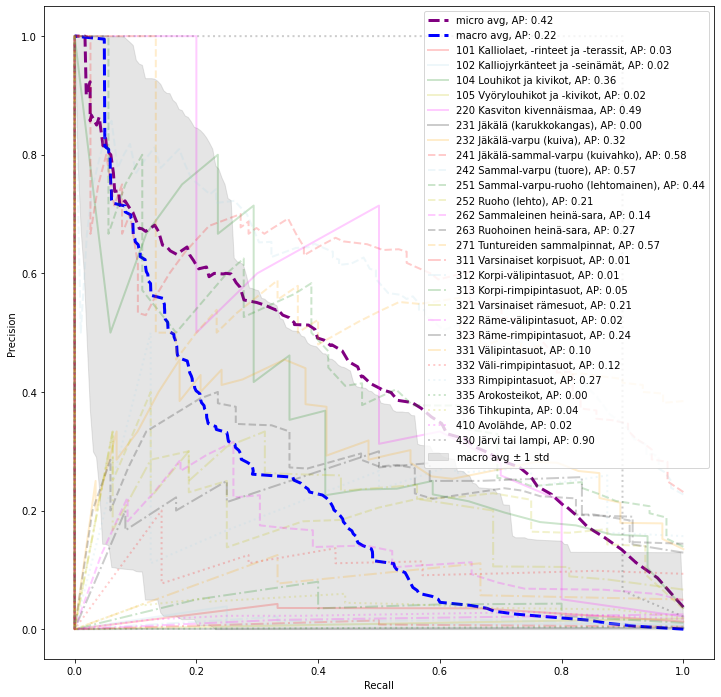

In [68]:
def plot_precision_recall_curve(precision, recall, linestyles):
    recalls_upper = np.minimum(recall["macro"] + recall["macro_std"], 1)
    recalls_lower = np.maximum(recall["macro"] - recall["macro_std"], 0)

    # Save vals

    plt.figure(figsize=(12,12))
    plt.plot(recall['micro'], precision['micro'], label=f'micro avg, AP: {average_precision["micro"]:.2f}', lw=3, ls='--', color='purple')
    plt.plot(recall['macro'], precision['macro'], label=f'macro avg, AP: {average_precision["macro"]:.2f}', lw=3, ls='--', color='blue')
    plt.fill_between(all_precision, recalls_lower, recalls_upper, color='grey', alpha=.2, label=r'macro avg $\pm$ 1 std')

    for i in range(N_CLASSES):
        plt.plot(recall[i], 
                precision[i], 
                lw=2, 
                label=le.inverse_transform([i])[0] + f', AP: {average_precision[i]:.2f}', 
                color=combs[i][0], 
                ls=combs[i][1],
                alpha=0.2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

In [67]:
average_precision['micro']

0.4189050431951382

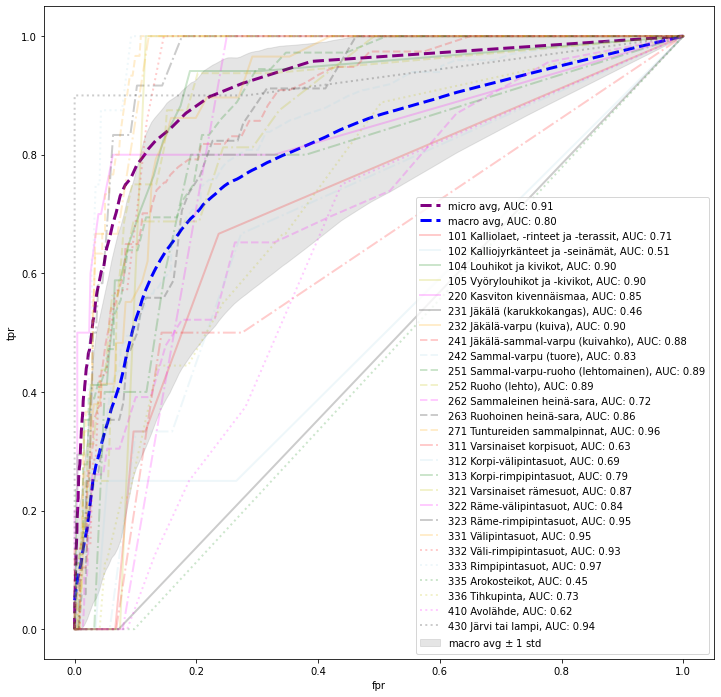

In [69]:
# Micro avg

def plot_roc_auc_curve(tpr, fpr):
    tprs_upper = np.minimum(tpr["macro"] + tpr["macro_std"], 1)
    tprs_lower = np.maximum(tpr["macro"] - tpr["macro_std"], 0)

    # Figure
    plt.figure(figsize=(12,12))
    plt.plot(fpr['micro'], tpr['micro'], label=f'micro avg, AUC: {roc_auc["micro"]:.2f}', lw=3, ls='--', color='purple')
    plt.plot(fpr['macro'], tpr['macro'], label=f'macro avg, AUC: {roc_auc["macro"]:.2f}', lw=3, ls='--', color='blue')
    plt.fill_between(all_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'macro avg $\pm$ 1 std')
    for i in range(N_CLASSES):
        plt.plot(fpr[i], 
                tpr[i], 
                lw=2, 
                label=le.inverse_transform([i])[0]+f', AUC: {roc_auc[i]:.2f}', 
                color=combs[i][0], 
                ls=combs[i][1], 
                alpha=0.2)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.legend()

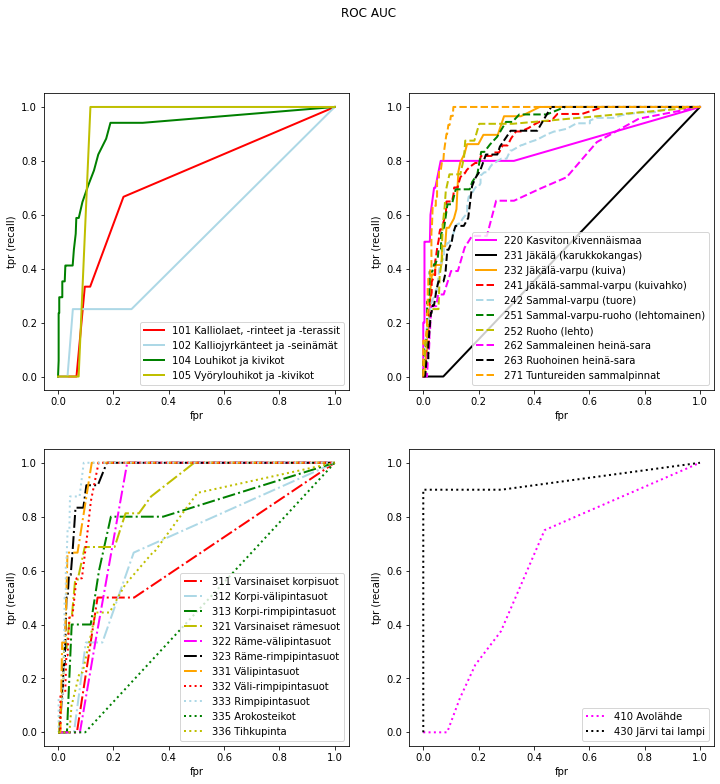

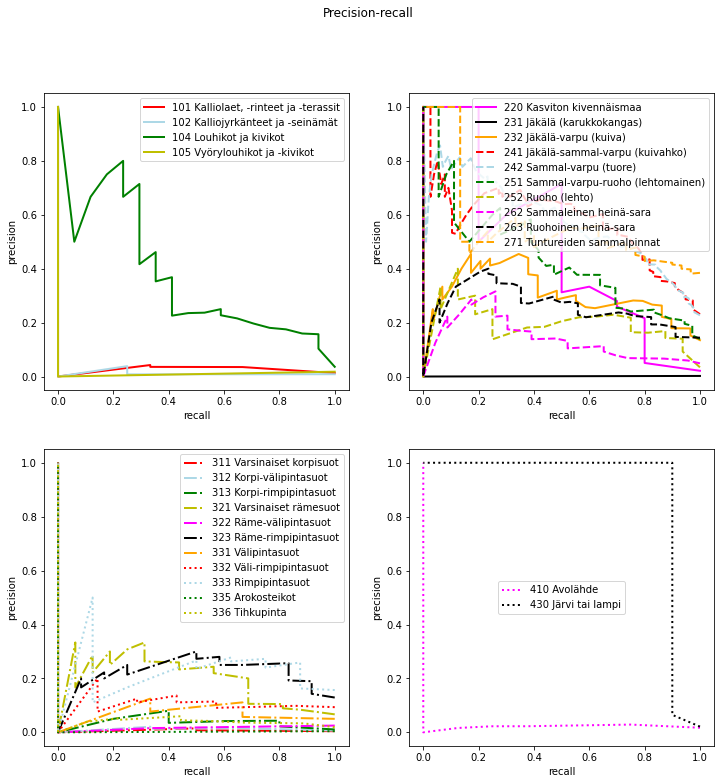

In [70]:
def show_subplot(ax, x,y, lab, r):
    for i in range(r[0],r[1]):
        ax.plot(x[i], y[i], lw=2, label=le.inverse_transform([i])[0], color=combs[i][0], ls=combs[i][1])
    ax.set_xlabel(lab[0])
    ax.set_ylabel(lab[1])
    ax.legend()

fig, axes = plt.subplots(2,2, figsize=(12,12))
fig.suptitle('ROC AUC')
axes = axes.ravel()
show_subplot(axes[0], fpr, tpr, ('fpr', 'tpr (recall)'), (0,4))
show_subplot(axes[1], fpr, tpr, ('fpr', 'tpr (recall)'), (4,14))
show_subplot(axes[2], fpr, tpr, ('fpr', 'tpr (recall)'), (14,25))
show_subplot(axes[3], fpr, tpr, ('fpr', 'tpr (recall)'), (25,27))

fig, axes = plt.subplots(2,2, figsize=(12,12))
fig.suptitle('Precision-recall')
axes = axes.ravel()
show_subplot(axes[0], recall, precision, ('recall', 'precision'), (0,4))
show_subplot(axes[1], recall, precision, ('recall', 'precision'), (4,14))
show_subplot(axes[2], recall, precision, ('recall', 'precision'), (14,25))
show_subplot(axes[3], recall, precision, ('recall', 'precision'), (25,27))

<AxesSubplot:>

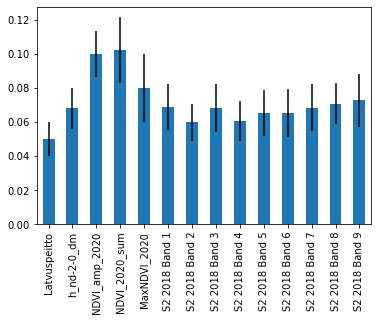

In [5]:
feature_importances = clf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in clf.estimators_], axis=0)
feature_names = ['Latvuspeitto',
                 'h_nd-2-0_dm',
                 'NDVI_amp_2020',
                 'NDVI_2020_sum',
                 'MaxNDVI_2020'] + [f'S2 2018 Band {i+1}' for i in range(9)]

fig, ax = plt.subplots()
pd.Series(feature_importances, index=feature_names).plot.bar(yerr=std, ax=ax)

[Parallel(n_jobs=40)]: Using backend ThreadingBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done 100 out of 100 | elapsed:    0.0s finished


Text(0.5, 1.0, 'Feature importances Inventointiluokka, testset')

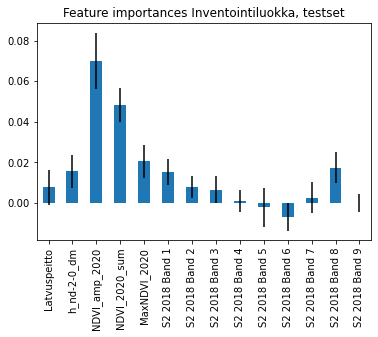

In [7]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
                clf, 
                X_test, 
                y_test, 
                n_repeats=10, 
                random_state=666, 
                n_jobs=-1)

fig, ax = plt.subplots()
pd.Series(result.importances_mean, index=feature_names).plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title('Feature importances Inventointiluokka, testset')

In [10]:
plt.tight_layout()
fig.savefig('feature_importances_natura.jpg', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>